## High-z galaxies with Te measurements

# Strong line methods Analysis

In [1]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table

## colors and markers
colors = plt.get_cmap('cubehelix_r')(np.linspace(0.1, 0.8, 17))
markers = ('>','+','v','D','H','+','s','o','<','X','p','*','^','d','h','x','8')

## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

#Probably there is a smart way of doing this with PyNeb
super_wav = {
    'OIII1661': 1661,
    'OIII1666': 1666,
    'NIII1750': 1750,
    'CIII1907': 1907,
    'CIII1909': 1909,
    'NeIII3869': 3869,
    'OII3727': 3727,
    'OII3729': 3729,
    'OIITot': 3729,
    'Hd': 4102,
    'Hg': 4340,
    'OIII4363': 4363,
    'Hb': 4861,
    'OIII4959': 4959,
    'OIII5007': 5007,
    'Ha': 6563,
    'NII6584': 6584
    }

### Maiolino 2008

In [2]:
## Maiolino calibrations. ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval
err_calib = 0.10

def R23_Maiolino2008(met):
    """ From Maiolino+08
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        R23 ratio  ((F([OII]3727) + F([OIII]4959) + F([OIII]5007))/F(Hb))
    """
    c0,c1,c2,c3,c4 =  0.7462, -0.7149, -0.9401, -0.6154, -0.2524
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))
    
    
def OIII_5007_Hb_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in 12 + log (O/H) (has to be converted to 12 + log(O/H)- 8.69)
    Output:
    ------- 
        OIII5007 / H beta ratio 
    """
    c0,c1,c2,c3 =  0.1549, -1.5031, -0.9790, -0.0297
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def OII_3727_Hb_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        OII doublet / H beta ratio 
    """
    c0,c1,c2,c3,c4 = 0.5603, 0.0450, -1.8017, -1.8434, -0.6549
    return (10**polyval(met-8.69,(c0,c1,c2)))


def OIII_5007_OII_3727_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69 
    Output:
    ------- 
        OIII 5007 / OII doublet 
    """
    c0,c1,c2 = -0.2839, -1.3881, -0.3172
    return (10**polyval(met-8.69,(c0,c1,c2)))


def NeIII_3870_OII_3727_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        NeIII 3870 / OII doublet 
    """
    c0,c1,c2 = -1.2608, -1.0861, -0.1470
    return (10**polyval(met-8.69,(c0,c1,c2)))
    

def NII_6584_Ha_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        NII 6584 / Ha 
    """
    c0,c1,c2,c3,c4 = -0.7732, 1.2357, -0.2811, -0.7201, -0.3330    
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))
    

def OIII_5007_NII_6584_Maiolino2008(met):
    """ From Maiolino+08 
    Parameters:
    -----------
    met : float
       metallicity in log (Z/Zsun) = 12 + log (O/H) - 8.69
    Output:
    ------- 
        OIII 5007 / NII 6584 
    """
    c0,c1,c2,c3 = 0.4520, -2.6096, -0.7170, 0.1347 
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))    

In [3]:
## Minimising function
from lmfit import minimize, Parameters

def minimise_func(params,R,calib):
    return calib(params['met'])-R

dered_fluxes = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

R23_Maiolino08 = []
NII_Ha_Maiolino08 = []
OIII_Hb_Maiolino08 = []
O32_Maiolino08 = []
OII_Hb_Maiolino08 =[]
OIII_NII_Maiolino08 =[]
Ne_OII_Maiolino08 = []

for f in dered_fluxes:
    
    print('*******************',f['Name'],'*******************')
    params = Parameters()
    params.add('met', value=6.2, min=6.00, max=8.5) # can be used to isolate high-met from low-met branch
    params.pretty_print()

    
    ## R23
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    if np.isfinite(R):
        fit = minimize(minimise_func, params,args=(R,R23_Maiolino2008))
        R23_Maiolino08.append(fit.params['met'].value)
        print('R23 metallicity %0.2f'%fit.params['met'].value)
    else:
        R23_Maiolino08.append(np.nan)
        print('No R23 metallicity')
        
                       
    ## NII/Ha
    R = f['NII6584']/f['Ha']
    if np.isfinite(R):
        params['met'].set(value=6.3, min=6.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,NII_6584_Ha_Maiolino2008))
        NII_Ha_Maiolino08.append(fit.params['met'].value)
        print('NII/Ha metallicity %0.2f'%fit.params['met'].value)
    else:
        NII_Ha_Maiolino08.append(np.nan)
        print('No NII/Ha metallicity')                
    
                       
    ## OIII/Hb
    R = f['OIII5007']/f['Ha']
    if np.isfinite(R):
        params['met'].set(value=6.3, min=6.00, max=8.5)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_Hb_Maiolino2008))
        OIII_Hb_Maiolino08.append(fit.params['met'].value)
        print('OIII/Hb metallicity %0.2f'%fit.params['met'].value)
    else:
        OIII_Hb_Maiolino08.append(np.nan)
        print('No OIII/Hb metallicity')                
    
                       
    ## O32
    R = f['OIII5007']/f['OIITot']
    if np.isfinite(R):
        params['met'].set(value=6.3, min=6.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_OII_3727_Maiolino2008))
        O32_Maiolino08.append(fit.params['met'].value)
        print('O32 metallicity %0.2f'%fit.params['met'].value)
    else:
        O32_Maiolino08.append(np.nan)
        print('No O32 metallicity')
     
                       
    ## OII/Hb
    R = f['OIITot']/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=6.3, min=6.00, max=8.7)
        fit = minimize(minimise_func, params,args=(R,OII_3727_Hb_Maiolino2008))
        OII_Hb_Maiolino08.append(fit.params['met'].value)
        print('OII/Hb metallicity %0.2f'%fit.params['met'].value)
    else:
        OII_Hb_Maiolino08.append(np.nan)
        print('No OII/Hb metallicity')
               
                       
    ## OIII/NII
    R = f['OIII5007']/f['NII6584']
    if np.isfinite(R):
        params['met'].set(value=6.3, min=6.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,OIII_5007_NII_6584_Maiolino2008))
        OIII_NII_Maiolino08.append(fit.params['met'].value)
        print('OIII/NII metallicity %0.2f'%fit.params['met'].value)
    else:
        OIII_NII_Maiolino08.append(np.nan)
        print('No OIII/NII metallicity')
    
    
    ## Ne/OII
    R = f['NeIII3869']/f['OIITot']
    if np.isfinite(R):
        params['met'].set(value=6.3, min=6.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,NeIII_3870_OII_3727_Maiolino2008))
        Ne_OII_Maiolino08.append(fit.params['met'].value)
        print('Ne/OII metallicity %0.2f'%fit.params['met'].value)
    else:
        Ne_OII_Maiolino08.append(np.nan)
        print('No Ne/OII metallicity')                               


('*******************', 'COSMOS_12805', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met       6.2        6      8.5     None     True     None
R23 metallicity 8.05
NII/Ha metallicity 8.14
OIII/Hb metallicity 8.50
O32 metallicity 8.18
OII/Hb metallicity 6.30
OIII/NII metallicity 8.04
No Ne/OII metallicity
('*******************', 'SMACS_0304', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met       6.2        6      8.5     None     True     None
R23 metallicity 8.21
NII/Ha metallicity 8.10
OIII/Hb metallicity 8.50
O32 metallicity 8.25
OII/Hb metallicity 6.30
OIII/NII metallicity 6.66
Ne/OII metallicity 8.29
('*******************', 'BX74', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met       6.2        6      8.5     None     True     None
R23 metallicity 8.05
NII/Ha metallicity 8.13
OIII/Hb metallicity 8.47
O32 metallicity 7.70
OII/Hb metallicity 6.30
OIII/NII metallicity 

<IPython.core.display.Javascript object>


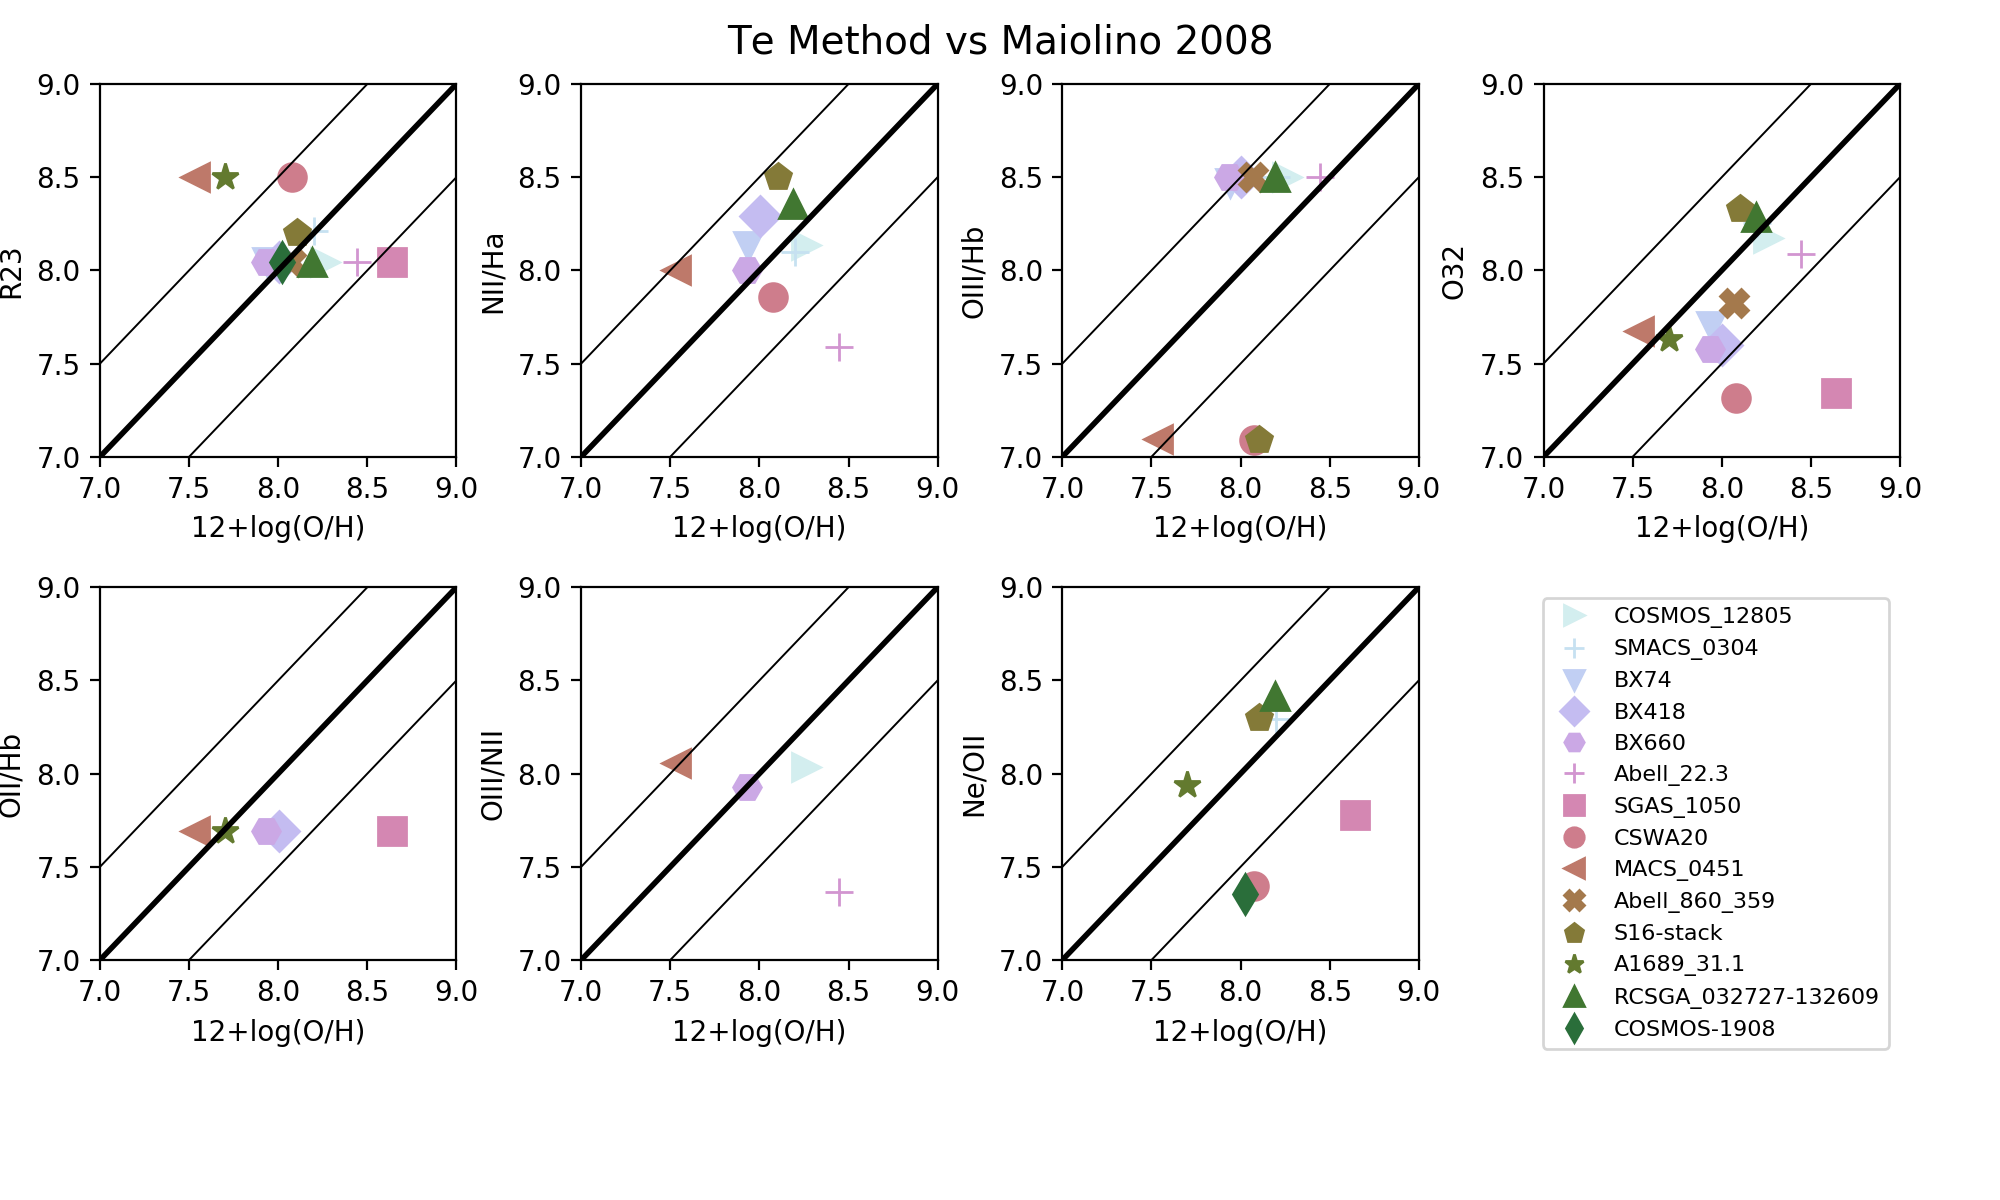

In [4]:
## Compare with direct method
direct_Te = Table.read('Pyneb_Te_method.dat',format='ascii.fixed_width_two_line')

fig, ax = plt.subplots(2,4,figsize=(10,6))
fig.suptitle('Te Method vs Maiolino 2008',fontsize=14)
ax = ax.ravel()
fig.subplots_adjust(top=0.93,bottom=0.2,right=0.95,left=0.05,hspace=0.35,wspace=0.35)

for i,gal in enumerate(direct_Te):

    ax[0].plot(gal['12+log(O/H)'],R23_Maiolino08[i],     marker=markers[i],color=colors[i],markersize=10)
    ax[1].plot(gal['12+log(O/H)'],NII_Ha_Maiolino08[i],  marker=markers[i],color=colors[i],markersize=10)
    ax[2].plot(gal['12+log(O/H)'],OIII_Hb_Maiolino08[i], marker=markers[i],color=colors[i],markersize=10)
    ax[3].plot(gal['12+log(O/H)'],O32_Maiolino08[i],     marker=markers[i],color=colors[i],markersize=10)
    ax[4].plot(gal['12+log(O/H)'],OII_Hb_Maiolino08[i],  marker=markers[i],color=colors[i],markersize=10)
    ax[5].plot(gal['12+log(O/H)'],OIII_NII_Maiolino08[i],marker=markers[i],color=colors[i],markersize=10)
    ax[6].plot(gal['12+log(O/H)'],Ne_OII_Maiolino08[i],  marker=markers[i],color=colors[i],markersize=10)
 
    # just for labels
    ax[7].plot(np.nan,np.nan,label=gal['Name'],marker=markers[i],color=colors[i],markersize=7,linewidth=0.)

# set limits and 1:1 ralation
for x in ax[0:7]:
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
    x.set_ylim(7.0,9.0)
    x.set_xlim(7.0,9.0)
    x.set_xlabel('12+log(O/H)')

    
# Set titles
ax[0].set_ylabel('R23')
ax[1].set_ylabel('NII/Ha')
ax[2].set_ylabel('OIII/Hb')
ax[3].set_ylabel('O32')
ax[4].set_ylabel('OII/Hb')
ax[5].set_ylabel('OIII/NII')
ax[6].set_ylabel('Ne/OII')

ax[7].axis('off')
ax[7].legend(loc=1,fontsize=8)

## Probably we would want to put a couple of diagnostics together and minimise them

## Curtis 2017

https://arxiv.org/pdf/1610.06939.pdf

Available diagnostics
- R2 = [O II] λ3727/Hβ
- R3 = [O III] λ5007/Hβ
- O32 = [O III] λ5007/[O II] λ3727
- R23 = ([O III] λ4959,5007 + [O II] λ3727)/Hβ
- N2 = [N II] λ6583/Hα
- O3N2 = R3/N2

In [6]:
## Curtis 2016 calibrations. Ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def R2_Curtis16(met):
    """ From Curtis+16. Range 7.6 < 12+log(O/H) < 8.3. Error 0.26.
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O II] λ3727 / H beta
    """
    c0,c1,c2,c3 =  0.418, -0.961, -3.505, -1.949
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def R3_Curtis16(met):
    """ From Curtis+16. Range 8.3 < 12+log(O/H) < 8.85. Error 0.07
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O III] λ5007 / Hbeta
    """
    c0,c1,c2,c3 = -0.277, -3.549, -3.593, -0.981        
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def R23_Curtis16(met):
    """ From Curtis+16. Range  8.4 < 12+log(O/H) < 8.85. Error 0.12
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        ([O III] λ4959,5007 + [O II] λ3727)/Hβ
    """
    c0,c1,c2,c3 = 0.527, -1.569, -1.652, -0.421        
    return (10**polyval(met-8.69,(c0,c1,c2,c3)))


def N2_Curtis16(met):
    """ From Curtis+16
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [N II] λ6583/Hα
    """
    c0,c1,c2,c3,c4  = -0.489, 1.513, -2.554, -5.293, -2.867     
    return (10**polyval(met-8.69,(c0,c1,c2,c3,c4)))


def O32_Curtis16(met):
    """ From Curtis+16. Range 7.6 < 12+log(O/H) < 8.85. Error 0.10
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        [O III] λ5007/[O II] λ3727
    """
    c0,c1,c2 = -0.691, -2.944, -1.308       
    return (10**polyval(met-8.69,(c0,c1,c2)))

def O3N2_Curtis16(met):
    """ From Curtis+16. Range 7.6 < 12+log(O/H) < 8.85. Error 0.09
    Parameters:
    -----------
    met : float
       metallicity normalised to the solar metallicity (8.69 Alende Prieto et. al. 2001)
    Output:
    ------- 
        R3/N2
    """
    c0,c1,c2 = 0.281, -4.765, -2.268       
    return (10**polyval(met-8.69,(c0,c1,c2)))

In [7]:
## Minimising function
from lmfit import minimize, Parameters

def minimise_func(params,R,calib):
    return calib(params['met'])-R

dered_fluxes = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

R2_Curtis = []
R3_Curtis = []
O32_Curtis = []
R23_Curtis = []
N2_Curtis = []
O3N2_Curtis = []

for f in dered_fluxes:
    
    print('*******************',f['Name'],'*******************')
    params = Parameters()
    params.add('met', value=8.0, min=7.6, max=8.3) 
    params.pretty_print()

    
    ## R2
    R = f['OIITot']/f['Hb']
    if np.isfinite(R):
        fit = minimize(minimise_func, params,args=(R,R2_Curtis16))
        R2_Curtis.append(fit.params['met'].value)
        print('R2 metallicity %0.2f'%fit.params['met'].value)
    else:
        R2_Curtis.append(np.nan)
        print('No R2 metallicity')
        
                       
    ## R3
    R = f['OIII5007']/f['Ha']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=8.85)
        fit = minimize(minimise_func, params,args=(R,R3_Curtis16))
        R3_Curtis.append(fit.params['met'].value)
        print('R3 metallicity %0.2f'%fit.params['met'].value)
    else:
        R3_Curtis.append(np.nan)
        print('No R3 metallicity')                
    
             
    ## R23
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=8.5)
        fit = minimize(minimise_func, params,args=(R,R23_Curtis16))
        R23_Curtis.append(fit.params['met'].value)
        print('R23 metallicity %0.2f'%fit.params['met'].value)
    else:
        R23_Curtis.append(np.nan)
        print('No R23 metallicity')                
    
    
    ## O32
    R = f['OIII5007']/f['OIITot']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,O32_Curtis16))
        O32_Curtis.append(fit.params['met'].value)
        print('O32 metallicity %0.2f'%fit.params['met'].value)
    else:
        O32_Curtis.append(np.nan)
        print('No O32 metallicity')
     
        
    ## N2
    R = f['NII6584']/f['Ha']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=8.7)
        fit = minimize(minimise_func, params,args=(R,N2_Curtis16))
        N2_Curtis.append(fit.params['met'].value)
        print('N2 metallicity %0.2f'%fit.params['met'].value)
    else:
        N2_Curtis.append(np.nan)
        print('No OII/Hb metallicity')
               
                       
    ## O3N2 = R3/N2
    R = (f['OIII5007']/f['Ha'])/(f['NII6584']/f['Ha'])
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=9.2)
        fit = minimize(minimise_func, params,args=(R,O3N2_Curtis16))
        O3N2_Curtis.append(fit.params['met'].value)
        print('O3N2 metallicity %0.2f'%fit.params['met'].value)
    else:
        O3N2_Curtis.append(np.nan)
        print('No O3N2 metallicity')


('*******************', 'COSMOS_12805', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met         8      7.6      8.3     None     True     None
R2 metallicity 8.30
R3 metallicity 7.31
R23 metallicity 8.07
O32 metallicity 8.25
N2 metallicity 8.16
O3N2 metallicity 8.29
('*******************', 'SMACS_0304', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met         8      7.6      8.3     None     True     None
R2 metallicity 8.30
R3 metallicity 6.94
R23 metallicity 7.84
O32 metallicity 8.30
N2 metallicity 8.13
O3N2 metallicity 8.34
('*******************', 'BX74', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met         8      7.6      8.3     None     True     None
R2 metallicity 8.05
R3 metallicity 7.42
R23 metallicity 8.07
O32 metallicity 7.94
N2 metallicity 8.15
O3N2 metallicity 8.26
('*******************', 'BX418', '*******************')
Name     Value      Min      Max   S

<IPython.core.display.Javascript object>


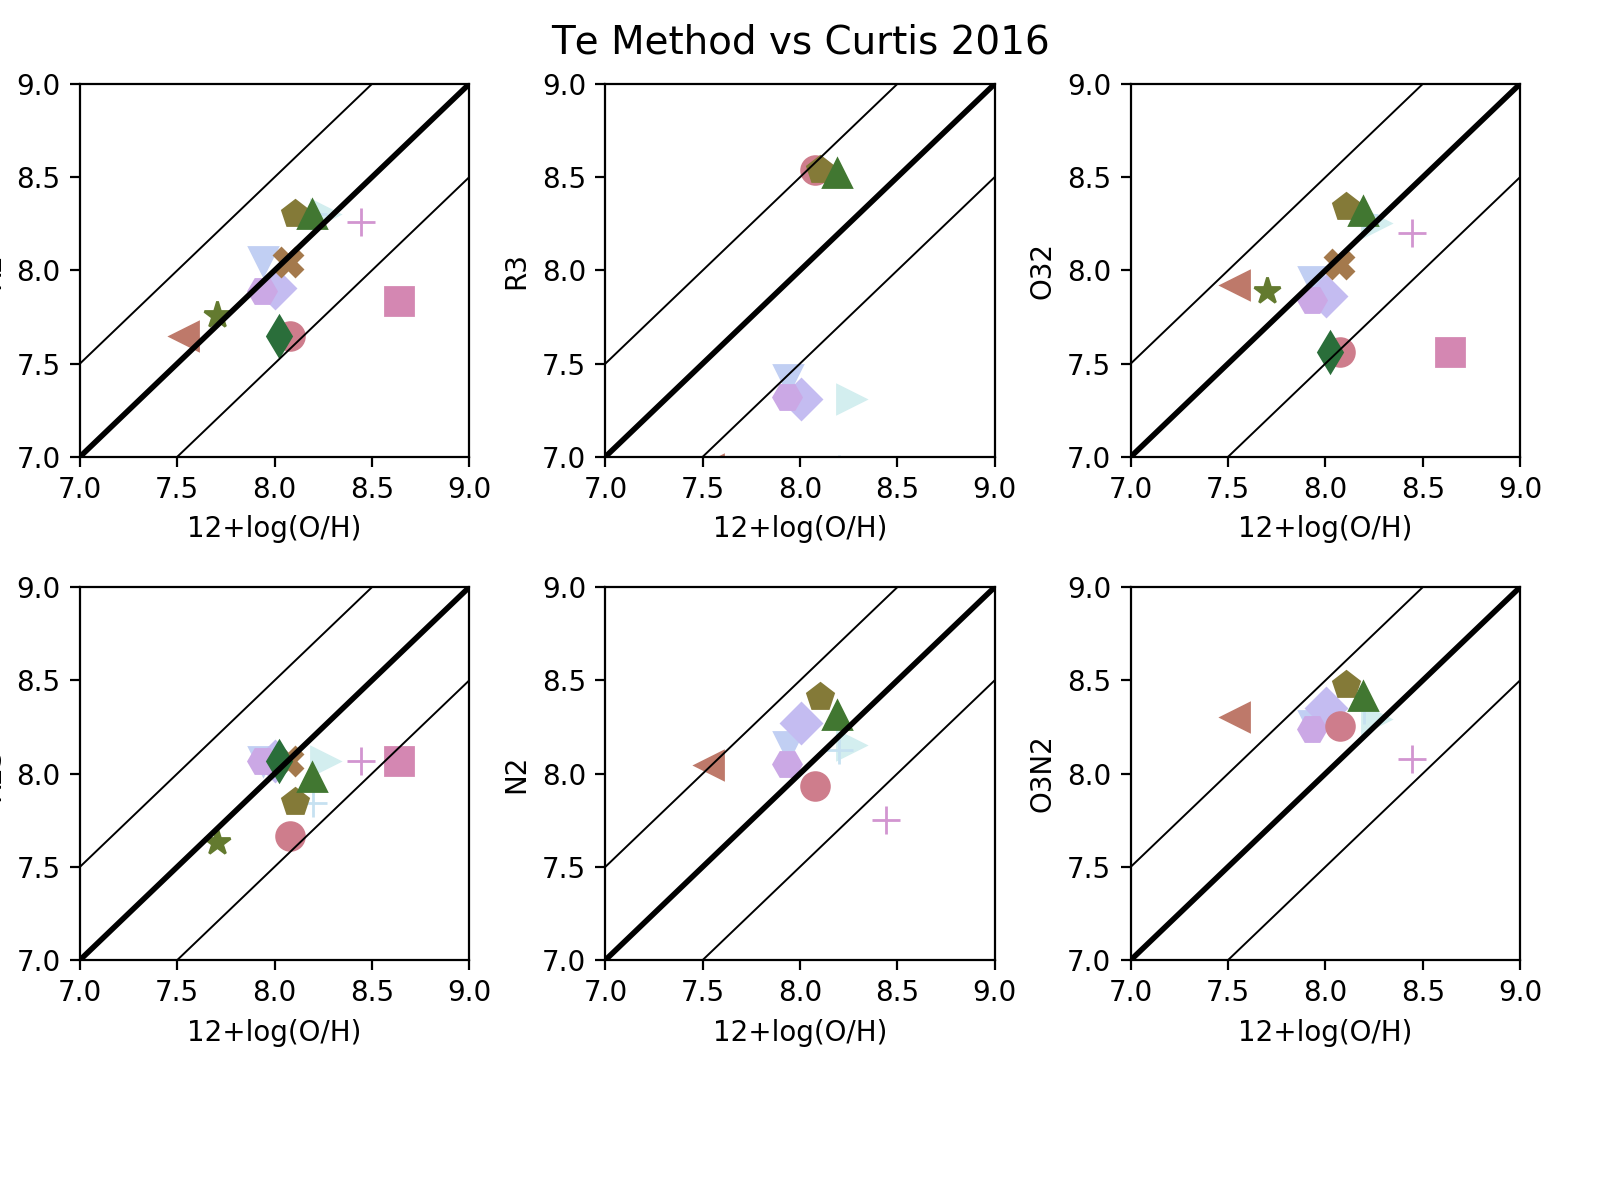

In [8]:
## Compare with direct method
direct_Te = Table.read('Pyneb_Te_method.dat',format='ascii.fixed_width_two_line')

fig, ax = plt.subplots(2,3,figsize=(8,6))
fig.suptitle('Te Method vs Curtis 2016',fontsize=14)
ax = ax.ravel()
fig.subplots_adjust(top=0.93,bottom=0.2,right=0.95,left=0.05,hspace=0.35,wspace=0.35)

for i,gal in enumerate(direct_Te):
    
    ax[0].plot(gal['12+log(O/H)'],R2_Curtis[i],     marker=markers[i],color=colors[i],markersize=10)
    ax[1].plot(gal['12+log(O/H)'],R3_Curtis[i],  marker=markers[i],color=colors[i],markersize=10)
    ax[2].plot(gal['12+log(O/H)'],O32_Curtis[i], marker=markers[i],color=colors[i],markersize=10)
    ax[3].plot(gal['12+log(O/H)'],R23_Curtis[i],     marker=markers[i],color=colors[i],markersize=10)
    ax[4].plot(gal['12+log(O/H)'],N2_Curtis[i],  marker=markers[i],color=colors[i],markersize=10)
    ax[5].plot(gal['12+log(O/H)'],O3N2_Curtis[i],marker=markers[i],color=colors[i],markersize=10)
    

# set limits and 1:1 ralation
for x in ax[0:7]:
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
    x.set_ylim(7.0,9.0)
    x.set_xlim(7.0,9.0)
    x.set_xlabel('12+log(O/H)')

# Set titles
ax[0].set_ylabel('R2')
ax[1].set_ylabel('R3')
ax[2].set_ylabel('O32')
ax[3].set_ylabel('R23')
ax[4].set_ylabel('N2')
ax[5].set_ylabel('O3N2')

## Jones 2015

In [11]:
## Jones 2015 calibrations. Ratio of lines in function of metallicity
from numpy.polynomial.polynomial import polyval

def NeO2_Jones15(met):
    """ From Jones+15. Error 0.22.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [Ne iii]/[O ii]
    """
    c0,c1 =  16.8974, -2.1588
    return (10**polyval(met,(c0,c1)))

def O32_Jones15(met):
    """ From Jones+15. Error 0.23.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O iii]/[O ii]
    """
    c0,c1 =  17.9828, -2.1552
    return (10**polyval(met,(c0,c1)))


def NeO3_Jones15(met):
    """ From Jones+15. Error 0.04.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [Ne iii]/[O iii]
    """
    c0,c1 = -1.0854, -0.0036
    return (10**polyval(met,(c0,c1)))


def O3_Jones15(met):
    """ From Jones+15. Error 0.10.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O iii]/H beta
    """
    c0,c1,c2 = -88.4378, 22.7529, -1.4501
    return (10**polyval(met,(c0,c1,c2)))


def O2_Jones15(met):
    """ From Jones+15. Error 0.15.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
        [O ii] / Hbeta
    """
    c0,c1,c2 = -154.9571, 36.9128, -2.1921
    return (10**polyval(met,(c0,c1,c2)))


def R23_Jones15(met):
    """ From Jones+15. Error 0.06.
    Parameters:
    -----------
    met : float
       12 + log(O/H)
    Output:
    ------- 
       R23
    """
    c0,c1,c2 = -54.1003, 13.9083, -0.8782
    return (10**polyval(met,(c0,c1,c2)))

In [12]:
## Minimising function
from lmfit import minimize, Parameters

def minimise_func(params,R,calib):
    return calib(params['met'])-R

dered_fluxes = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

NeO2_Jones = []
O32_Jones = []
NeO3_Jones = []
O3_Jones = []
O2_Jones = []
R23_Jones = []

for f in dered_fluxes:
    
    print('*******************',f['Name'],'*******************')
    params = Parameters()
    params.add('met', value=8.0, min=7.6, max=9.0) 
    params.pretty_print()

    ## NeOII
    R = f['NeIII3869']/f['OIITot']
    if np.isfinite(R):
        fit = minimize(minimise_func, params,args=(R,NeO2_Jones15))
        NeO2_Jones.append(fit.params['met'].value)
        print('NeO2 metallicity %0.2f'%fit.params['met'].value)
    else:
        NeO2_Jones.append(np.nan)
        print('No NeO2 metallicity')
 
    ## O32
    R = f['OIII5007']/f['OIITot']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,O32_Jones15))
        O32_Jones.append(fit.params['met'].value)
        print('O32 metallicity %0.2f'%fit.params['met'].value)
    else:
        O32_Jones.append(np.nan)
        print('No O32 metallicity')                
    
    ## NeOIII
    R = f['NeIII3869']/f['OIII5007']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,NeO3_Jones15))
        NeO3_Jones.append(fit.params['met'].value)
        print('NeO3 metallicity %0.2f'%fit.params['met'].value)
    else:
        NeO3_Jones.append(np.nan)
        print('No NeO3 metallicity')  
    
    ## O3
    R = f['OIII5007']/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,O3_Jones15))
        O3_Jones.append(fit.params['met'].value)
        print('O3 metallicity %0.2f'%fit.params['met'].value)
    else:
        O3_Jones.append(np.nan)
        print('No O3 metallicity') 
        
    ## O2
    R = f['OIITot']/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=7.6, max=9.0)
        fit = minimize(minimise_func, params,args=(R,O2_Jones15))
        O2_Jones.append(fit.params['met'].value)
        print('O2 metallicity %0.2f'%fit.params['met'].value)
    else:
        O2_Jones.append(np.nan)
        print('No O2 metallicity')  

    ## R23
    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    if np.isfinite(R):
        params['met'].set(value=8.0, min=6.00, max=8.5)
        fit = minimize(minimise_func, params,args=(R,R23_Jones15))
        R23_Jones.append(fit.params['met'].value)
        print('R23 metallicity %0.2f'%fit.params['met'].value)
    else:
        R23_Jones.append(np.nan)
        print('No R23 metallicity')                
    

('*******************', 'COSMOS_12805', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met         8      7.6        9     None     True     None
No NeO2 metallicity
O32 metallicity 8.18
No NeO3 metallicity
O3 metallicity 7.90
O2 metallicity 8.42
R23 metallicity 7.92
('*******************', 'SMACS_0304', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met         8      7.6        9     None     True     None
NeO2 metallicity 8.22
O32 metallicity 8.22
NeO3 metallicity 8.49
O3 metallicity 8.17
O2 metallicity 8.29
R23 metallicity 8.13
('*******************', 'BX74', '*******************')
Name     Value      Min      Max   Stderr     Vary     Expr
met         8      7.6        9     None     True     None
No NeO2 metallicity
O32 metallicity 7.98
No NeO3 metallicity
O3 metallicity 7.85
O2 metallicity 8.03
R23 metallicity 7.92
('*******************', 'BX418', '*******************')
Name     Value      Min      Max   Std

<IPython.core.display.Javascript object>


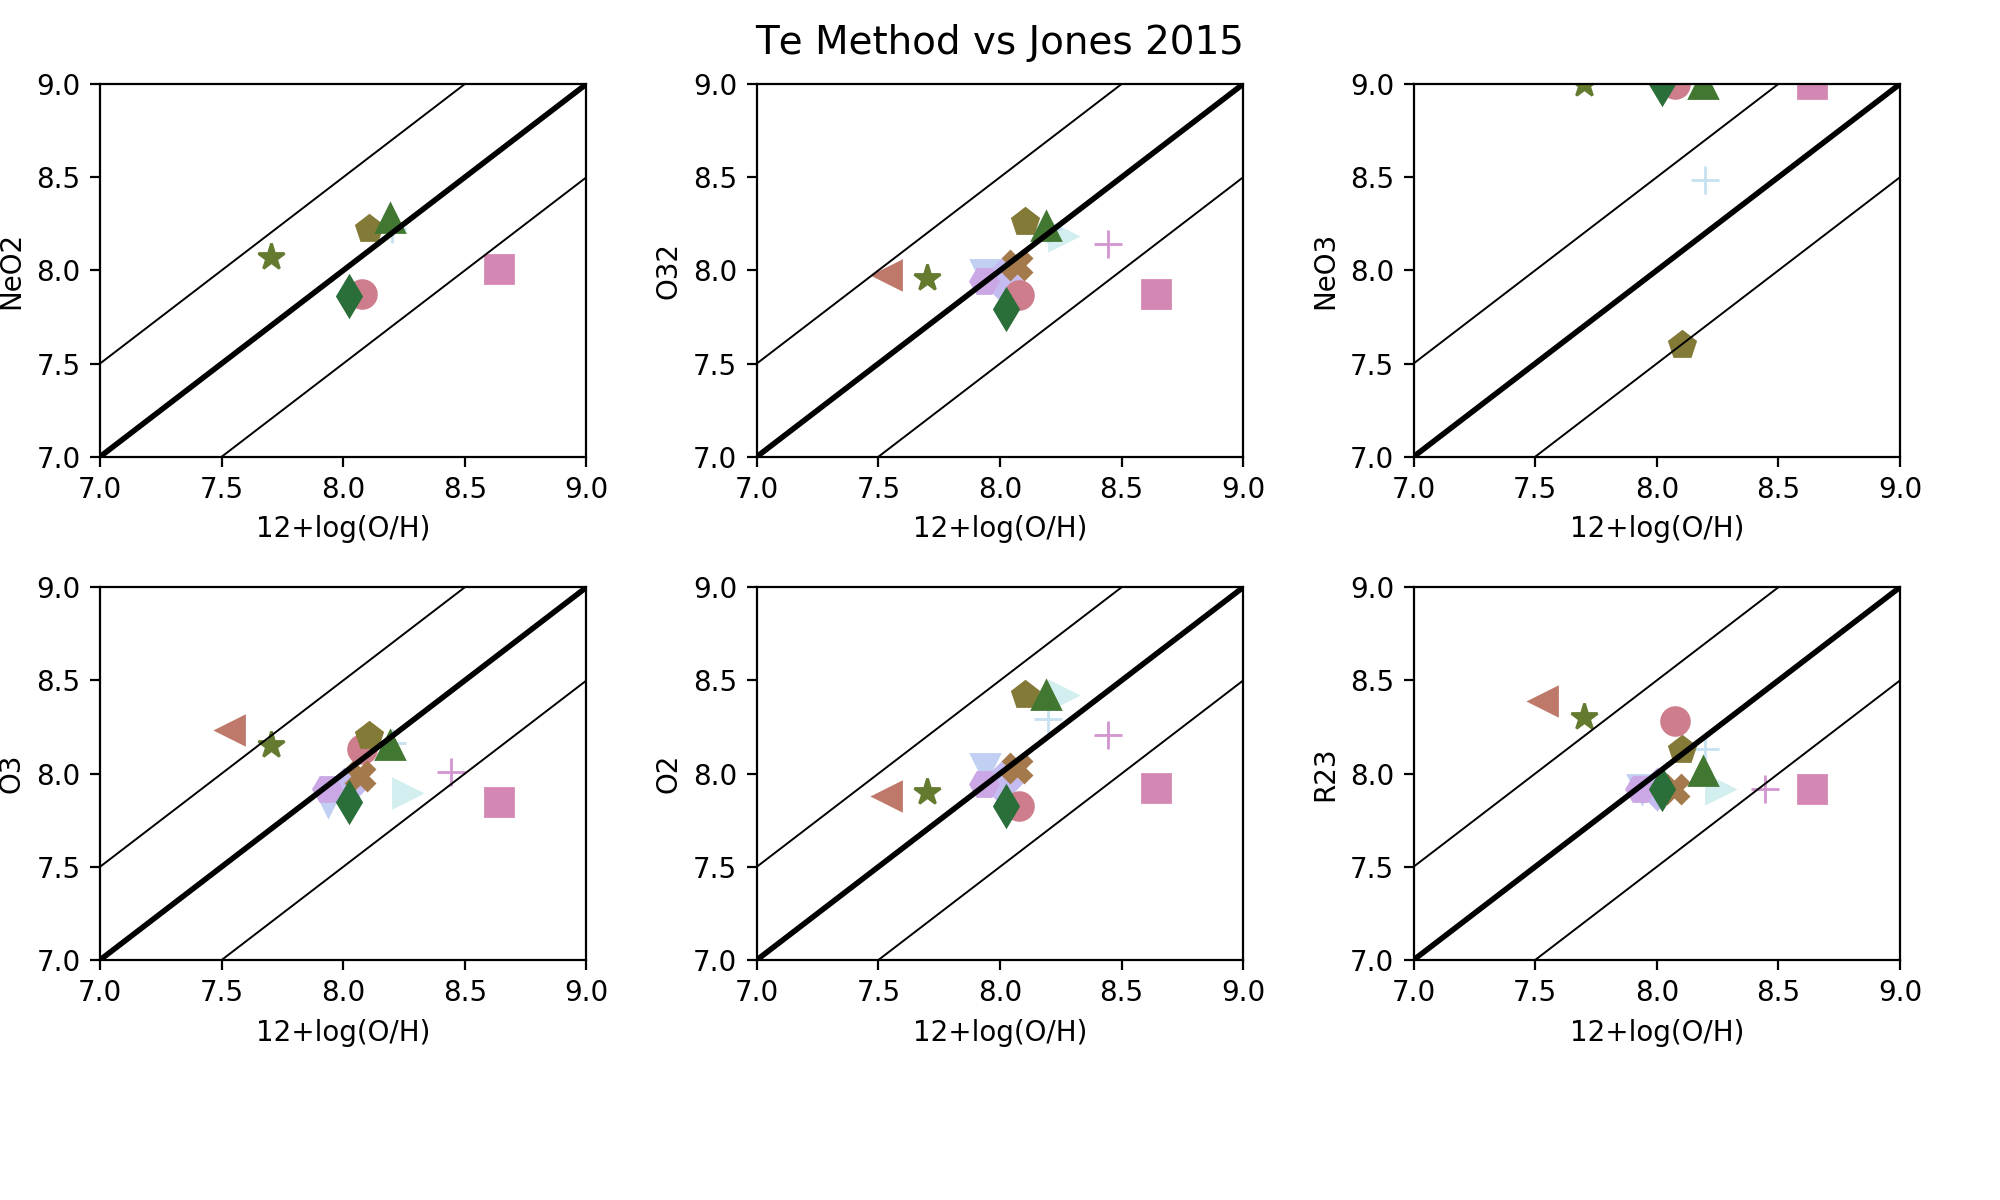

In [13]:
## Compare with direct method
direct_Te = Table.read('Pyneb_Te_method.dat',format='ascii.fixed_width_two_line')

fig, ax = plt.subplots(2,3,figsize=(10,6))
fig.suptitle('Te Method vs Jones 2015',fontsize=14)
ax = ax.ravel()
fig.subplots_adjust(top=0.93,bottom=0.2,right=0.95,left=0.05,hspace=0.35,wspace=0.35)

for i,gal in enumerate(direct_Te):
    
    ax[0].plot(gal['12+log(O/H)'],NeO2_Jones[i],     marker=markers[i],color=colors[i],markersize=10)
    ax[1].plot(gal['12+log(O/H)'],O32_Jones[i],  marker=markers[i],color=colors[i],markersize=10)
    ax[2].plot(gal['12+log(O/H)'],NeO3_Jones[i], marker=markers[i],color=colors[i],markersize=10)
    ax[3].plot(gal['12+log(O/H)'],O3_Jones[i],     marker=markers[i],color=colors[i],markersize=10)
    ax[4].plot(gal['12+log(O/H)'],O2_Jones[i],  marker=markers[i],color=colors[i],markersize=10)
    ax[5].plot(gal['12+log(O/H)'],R23_Jones[i],marker=markers[i],color=colors[i],markersize=10)
    

# set limits and 1:1 ralation
for x in ax[0:7]:
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
    x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
    x.set_ylim(7.0,9.0)
    x.set_xlim(7.0,9.0)
    x.set_xlabel('12+log(O/H)')

# Set titles
ax[0].set_ylabel('NeO2')
ax[1].set_ylabel('O32')
ax[2].set_ylabel('NeO3')
ax[3].set_ylabel('O3')
ax[4].set_ylabel('O2')
ax[5].set_ylabel('R23')

# Just comparing line ratios with metallicity

<IPython.core.display.Javascript object>


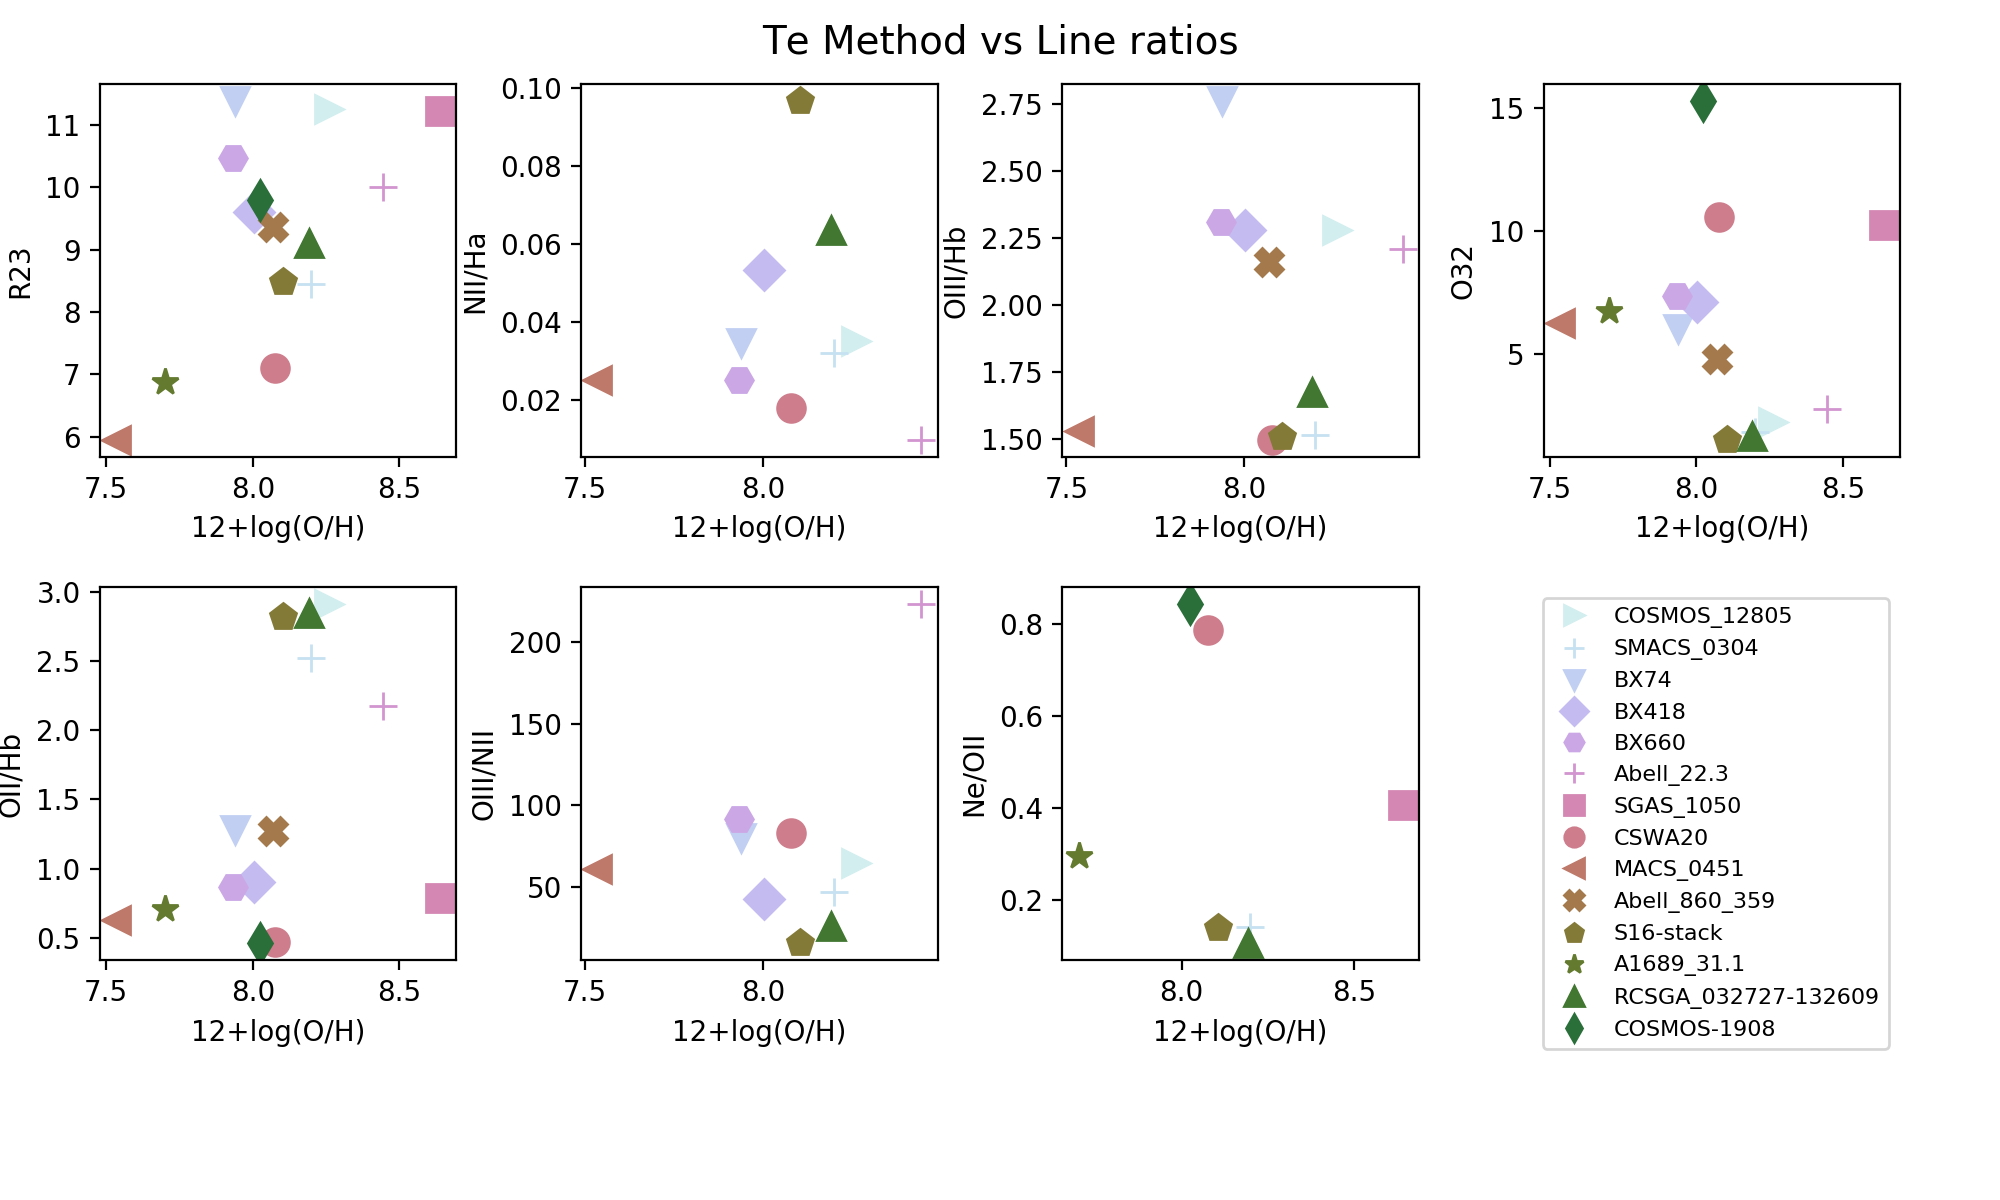

In [20]:
## Compare with direct method
direct_Te = Table.read('Pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
dered_fluxes = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

fig, ax = plt.subplots(2,4,figsize=(10,6))
fig.suptitle('Te Method vs Line ratios',fontsize=14)
ax = ax.ravel()
fig.subplots_adjust(top=0.93,bottom=0.2,right=0.95,left=0.05,hspace=0.35,wspace=0.35)

for i,(gal,f) in enumerate(zip(direct_Te,dered_fluxes)):

    R = (f['OIITot']+f['OIII4959']+f['OIII5007'])/f['Hb']
    ax[0].plot(gal['12+log(O/H)'],R, marker=markers[i],color=colors[i],markersize=10)
    R = f['NII6584']/f['Ha']
    ax[1].plot(gal['12+log(O/H)'],R, marker=markers[i],color=colors[i],markersize=10)
    R = f['OIII5007']/f['Ha']
    ax[2].plot(gal['12+log(O/H)'],R, marker=markers[i],color=colors[i],markersize=10)
    R = f['OIII5007']/f['OIITot']
    ax[3].plot(gal['12+log(O/H)'],R, marker=markers[i],color=colors[i],markersize=10)
    R = f['OIITot']/f['Hb']
    ax[4].plot(gal['12+log(O/H)'],R, marker=markers[i],color=colors[i],markersize=10)
    R = f['OIII5007']/f['NII6584']
    ax[5].plot(gal['12+log(O/H)'],R,marker=markers[i],color=colors[i],markersize=10)
    R = f['NeIII3869']/f['OIITot']
    ax[6].plot(gal['12+log(O/H)'],R,  marker=markers[i],color=colors[i],markersize=10)
 
    # just for labels
    ax[7].plot(np.nan,np.nan,label=gal['Name'],marker=markers[i],color=colors[i],markersize=7,linewidth=0.)

# set limits and 1:1 ralation
for x in ax[0:7]:
    #x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
    #x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
    #x.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
    #x.set_ylim(7.0,9.0)
    #x.set_xlim(7.0,9.0)
    x.set_xlabel('12+log(O/H)')

    
# Set titles
ax[0].set_ylabel('R23')
ax[1].set_ylabel('NII/Ha')
ax[2].set_ylabel('OIII/Hb')
ax[3].set_ylabel('O32')
ax[4].set_ylabel('OII/Hb')
ax[5].set_ylabel('OIII/NII')
ax[6].set_ylabel('Ne/OII')

ax[7].axis('off')
ax[7].legend(loc=1,fontsize=8)